In [14]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

In [15]:
df = pd.read_csv('./data/tcs_train.csv')
df.dropna(inplace=True)

In [16]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
733,2019-11-25,2074.550049,2084.949951,2052.199951,2081.500000,2081.500000,2737010.0
734,2019-11-26,2089.850098,2097.899902,2035.050049,2046.650024,2046.650024,6561580.0
735,2019-11-27,2052.000000,2071.699951,2046.550049,2054.300049,2054.300049,2907521.0
736,2019-11-28,2067.050049,2094.399902,2060.000000,2077.350098,2077.350098,2924429.0
737,2019-11-29,2085.000000,2085.000000,2045.800049,2053.250000,2053.250000,2064271.0


In [17]:
df.shape

(737, 7)

#### Data Preprocessing

In [18]:
df_train = df.iloc[:, 1:2].values
#df_train

In [19]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df_train_sc = sc.fit_transform(df_train)

In [20]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(90, 737):
    X_train.append(df_train_sc[i-90:i, 0])
    y_train.append(df_train_sc[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [21]:
X_train.shape,y_train.shape

((647, 90), (647,))

In [22]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(647, 90, 1)

In [23]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [24]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
647/647 [==============================] - 5s 7ms/step - loss: 0.0766
Epoch 2/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0138
Epoch 3/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0108
Epoch 4/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0084
Epoch 5/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0087
Epoch 6/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0085
Epoch 7/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 8/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 9/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0075
Epoch 10/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0077
Epoch 11/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 12/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0071
Epoch 13/100


647/647 [==============================] - 3s 5ms/step - loss: 0.0029
Epoch 100/100
647/647 [==============================] - 3s 5ms/step - loss: 0.0027


#### Making the predictions and visualising the results

In [33]:
# Getting the real stock price of 2017
df_test = pd.read_csv('./data/tcs_test.csv')
df_test.tail()
#df_test.shape

,Date,Open,High,Low,Close,Adj Close,Volume
17,2019-12-26,2216.399902,2229.000000,2195.199951,2201.949951,2201.949951,1880367
18,2019-12-27,2208.000000,2226.399902,2176.000000,2198.500000,2198.500000,2720261
19,2019-12-30,2207.000000,2225.000000,2177.100098,2183.199951,2183.199951,2288830
20,2019-12-31,2189.000000,2197.000000,2157.449951,2161.699951,2161.699951,1909289
21,2020-01-01,2168.000000,2183.899902,2154.000000,2167.600098,2167.600098,1354908


In [34]:
real_stock_price = df_test.iloc[:, 1:2].values

In [35]:
# Getting the predicted stock price 
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[len(df_total) - len(df_test) - 90:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [36]:
inputs.shape,df_total.shape

((112, 1), (759,))

In [37]:
X_test = []
for i in range(90, 112):
    X_test.append(inputs[i-90:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [38]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

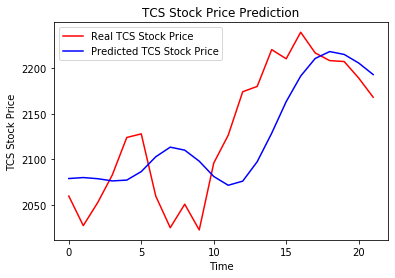

In [39]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real TCS Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TCS Stock Price')
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TCS Stock Price')
plt.legend()
plt.show()

In [32]:
pd.DataFrame({'real':real_stock_price.flatten(),'predicted':predicted_stock_price.flatten()})

,real,predicted
0,2060.000000,2079.148682
1,2027.699951,2080.210938
2,2053.000000,2078.967773
3,2083.000000,2076.533936
4,2124.000000,2077.447510
5,2127.949951,2086.719971
6,2060.000000,2102.912598
7,2025.400024,2113.438477
8,2051.100098,2110.142578
9,2023.000000,2098.117432
